In [13]:
import pandas as pd
import torch
import torch.nn.functional as F
import random
import numpy as np
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero

Load Data

In [14]:
def load_real_data():
    print("Veriler yükleniyor...")
    
    # 1. Places Dosyasını Oku (Encoding hatası düzeltildi)
    # 'latin-1' veya 'cp1252' genellikle Türkçe/Fransızca karakter içeren Windows dosyalarını çözer.
    places_df = pd.read_csv('paris_1000_mixed_places.csv', sep=';', encoding='latin-1')
    
    # 2. Users Dosyasını Oku
    # DİKKAT: Benim verdiğim users listesini kopyaladıysanız ayraç virgüldür (sep=',').
    # Excel'den "CSV (Noktalı virgül ile ayrılmış)" olarak kaydettiyseniz sep=';' yapın.
    # Aşağıdaki kod her iki durumu da dener:
    try:
        # Önce virgül ile dene (Benim verdiğim format)
        users_df = pd.read_csv('users.csv', sep=',')
        # Eğer tek sütun okursa (yani ayraç yanlışsa), noktalı virgül dene
        if users_df.shape[1] < 2:
            users_df = pd.read_csv('users.csv', sep=';', encoding='latin-1')
    except:
        # Hata verirse direkt noktalı virgül dene
        users_df = pd.read_csv('users.csv', sep=';', encoding='latin-1')

    # ID Mapping
    place_id_map = {id: i for i, id in enumerate(places_df['name'].unique())} 
    
    num_places = len(places_df)
    num_users = len(users_df)
    print(f"Toplam Mekân: {num_places}, Toplam Kullanıcı: {num_users}")

    # 3. Kategori İşleme (Place Features)
    # Boş veya hatalı kategorileri 'General' olarak doldur
    places_df['category'] = places_df['category'].fillna('General')
    
    # Kategorinin ilk kelimesini al
    places_df['simple_cat'] = places_df['category'].astype(str).apply(lambda x: x.split(',')[0].strip())
    unique_cats = places_df['simple_cat'].unique()
    cat_to_idx = {cat: i for i, cat in enumerate(unique_cats)}
    
    # Place Features (One-Hot Encoding)
    place_features = torch.zeros(num_places, len(unique_cats))
    for idx, row in places_df.iterrows():
        cat_idx = cat_to_idx.get(row['simple_cat'], 0)
        place_features[idx][cat_idx] = 1.0

    # 4. Kullanıcı İşleme (User Features)
    unique_personas = users_df['persona'].unique()
    persona_to_idx = {p: i for i, p in enumerate(unique_personas)}
    
    user_features = torch.zeros(num_users, len(unique_personas))
    for idx, row in users_df.iterrows():
        p_idx = persona_to_idx.get(row['persona'], 0)
        user_features[idx][p_idx] = 1.0

    # 5. Sentetik Etkileşim (Edge) Üretimi
    src_list = []
    dst_list = []
    
    interest_map = {
        "Culture & Arts Lover": ["Museums", "Landmarks", "Arts", "History"],
        "Gastronome": ["Restaurants", "French", "Cafes", "Wine"],
        "Night Owl": ["Bars", "Cocktail", "Nightlife", "Clubs"],
        "Nature Lover": ["Parks", "Gardens"],
        "Shopaholic": ["Shopping", "Fashion"],
        "Tourist": ["Hotels", "Landmarks", "Museums"]
    }
    print("Sentetik etkileşimler üretiliyor...")
    for u_idx, user in users_df.iterrows():
        user_persona = user['persona']
        liked_categories = interest_map.get(user_persona, [])
        
        # Rastgele 20 mekan seçip kontrol et
        # (Mekan sayısı az ise hata vermemesi için min alıyoruz)
        sample_size = min(20, num_places)
        sample_indices = random.sample(range(num_places), sample_size)
        
        for p_idx in sample_indices:
            place_cat = places_df.iloc[p_idx]['simple_cat']
            
            # Kategori eşleşmesi veya şans faktörü
            if any(interest in place_cat for interest in liked_categories) or random.random() < 0.1:
                src_list.append(u_idx)
                dst_list.append(p_idx)
    edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)
    print(f"Toplam Üretilen Bağlantı (Etkileşim): {edge_index.shape[1]}")
    data = HeteroData()
    data['user'].x = user_features
    data['place'].x = place_features
    data['user', 'rates', 'place'].edge_index = edge_index
    data['place', 'rated_by', 'user'].edge_index = edge_index.flip(0)
    
    return data, places_df, users_df

Model Architecture

In [15]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

In [16]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels):
        super().__init__()
        self.gnn = GNN(hidden_channels, out_channels)
        self.gnn = to_hetero(self.gnn, metadata, aggr='sum')
    def forward(self, x_dict, edge_index_dict):
        return self.gnn(x_dict, edge_index_dict)

Train Model

In [17]:
def train_model():
    # Veriyi Yükle
    data, places_df, users_df = load_real_data()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)

    # Model Parametreleri
    # Hidden channels'ı feature boyutuna göre ayarlamak iyi olur ama sabit de çalışır.
    model = HeteroGNN(data.metadata(), hidden_channels=32, out_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    print("\nModel Eğitimi Başlıyor...")
    
    for epoch in range(101):
        model.train()
        optimizer.zero_grad()
        
        # 1. Forward Pass
        node_embeddings = model(data.x_dict, data.edge_index_dict)
        
        # 2. Positive Sampling (Gerçek Bağlantılar)
        pos_edge_index = data['user', 'rates', 'place'].edge_index
        pos_user_emb = node_embeddings['user'][pos_edge_index[0]]
        pos_place_emb = node_embeddings['place'][pos_edge_index[1]]
        # Skor: Dot Product
        pos_scores = (pos_user_emb * pos_place_emb).sum(dim=1)
        
        # 3. Negative Sampling (Olmayan Bağlantılar - Rastgele)
        # Modelin "her şeye evet" demesini engellemek için
        neg_u = torch.randint(0, data['user'].num_nodes, (pos_edge_index.size(1),), device=device)
        neg_p = torch.randint(0, data['place'].num_nodes, (pos_edge_index.size(1),), device=device)
        
        neg_user_emb = node_embeddings['user'][neg_u]
        neg_place_emb = node_embeddings['place'][neg_p]
        neg_scores = (neg_user_emb * neg_place_emb).sum(dim=1)
        
        # 4. Loss (BCEWithLogitsLoss)
        # Pozitifler 1 olsun, Negatifler 0 olsun
        pos_loss = F.binary_cross_entropy_with_logits(pos_scores, torch.ones_like(pos_scores))
        neg_loss = F.binary_cross_entropy_with_logits(neg_scores, torch.zeros_like(neg_scores))
        loss = pos_loss + neg_loss
        
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss.item():.4f}")
    return model, data, places_df, users_df

Test and Recommendations

In [18]:
if __name__ == "__main__":
    model, data, places_df, users_df = train_model()
    
    print("\n--- ÖNERİ TESTİ ---")
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x_dict, data.edge_index_dict)
        
        # Test için bir kullanıcı seçelim (Örn: Index 3 -> Mehmet Williams / Culture Lover)
        test_user_idx = 3 
        user_info = users_df.iloc[test_user_idx]
        print(f"\nKullanıcı: {user_info['name']}")
        print(f"Persona: {user_info['persona']}")
        print(f"İlgi Alanları: {user_info['interests']}")
        
        # Tüm mekanlar için skor hesapla
        user_vec = embeddings['user'][test_user_idx]
        place_vecs = embeddings['place']
        
        # Matrix Multiplication ile skorlar
        scores = (place_vecs @ user_vec).sigmoid()
        
        # En yüksek 5 öneri
        top_k = 5
        top_scores, top_indices = torch.topk(scores, top_k)
        
        print(f"\nModelin Önerdiği Top {top_k} Mekân:")
        for score, idx in zip(top_scores, top_indices):
            idx = idx.item()
            place_name = places_df.iloc[idx]['name']
            place_cat = places_df.iloc[idx]['category']
            print(f"- {place_name} ({place_cat}) [Skor: {score:.4f}]")
# ... (Yukarıdaki kodlar aynı kalacak) ...

Veriler yükleniyor...
Toplam Mekân: 1000, Toplam Kullanıcı: 100
Sentetik etkileşimler üretiliyor...
Toplam Üretilen Bağlantı (Etkileşim): 436

Model Eğitimi Başlıyor...
Epoch: 000, Loss: 1.3831
Epoch: 010, Loss: 0.5323
Epoch: 020, Loss: 0.4069
Epoch: 030, Loss: 0.3165
Epoch: 040, Loss: 0.3527
Epoch: 050, Loss: 0.3279
Epoch: 060, Loss: 0.2643
Epoch: 070, Loss: 0.2779
Epoch: 080, Loss: 0.2822
Epoch: 090, Loss: 0.2898
Epoch: 100, Loss: 0.2674

--- ÖNERİ TESTİ ---

Kullanıcı: Mehmet Williams
Persona: Culture & Arts Lover
İlgi Alanları: museums, arts, landmarks

Modelin Önerdiği Top 5 Mekân:
- L'Alsacien (Beer Bar, Wine Bars, Alsatian) [Skor: 0.9857]
- Nina Kendosa (Women's Clothing, Accessories) [Skor: 0.9759]
- Variantes (Toy Stores) [Skor: 0.9746]
- Cité de l'Architecture et du Patrimoine (Museums) [Skor: 0.9694]
- Musée Jacquemart-André (Museums) [Skor: 0.9694]


In [19]:
def get_recommendations_for_user(user_name_or_id, model, data, places_df, users_df, top_k=5):
    """
    İsmi veya ID'si verilen kullanıcı için GNN modelini kullanarak öneri yapar.
    """
    model.eval()
    
    # 1. Kullanıcıyı Bul (Index Mapping)
    # Kullanıcı adında arama yap
    if isinstance(user_name_or_id, str):
        target_user = users_df[users_df['name'].str.contains(user_name_or_id, case=False, na=False)]
    else:
        # ID ise (örn: 1003)
        target_user = users_df[users_df['user_id'] == user_name_or_id]
        
    if target_user.empty:
        print(f"❌ Kullanıcı bulunamadı: {user_name_or_id}")
        return

    # Kullanıcının DataFrame'deki indeksini (0, 1, 2...) al
    # GNN tensörleri bu indekse göre çalışır.
    user_idx = target_user.index[0]
    real_user_id = target_user.iloc[0]['user_id']
    user_name = target_user.iloc[0]['name']
    user_persona = target_user.iloc[0]['persona']
    
    print(f"\n🔎 ANALİZ EDİLEN KULLANICI:")
    print(f"   ID: {real_user_id} | İsim: {user_name}")
    print(f"   Persona: {user_persona} (İlgi Alanları: {target_user.iloc[0]['interests']})")

    # 2. Embeddingleri Çek ve Hesapla
    with torch.no_grad():
        embeddings = model(data.x_dict, data.edge_index_dict)
        
        user_vec = embeddings['user'][user_idx]  # Seçilen kullanıcının vektörü
        place_vecs = embeddings['place']         # Tüm mekanların vektörleri
        
        # Skorlama: Dot Product + Sigmoid (0 ile 1 arası olasılık)
        scores = (place_vecs @ user_vec).sigmoid()
        
        # En yüksek skorlu Top K mekanı bul
        top_scores, top_indices = torch.topk(scores, top_k)
        
    # 3. Sonuçları Yazdır
    print(f"\n🎯 MODELİN ÖNERİLERİ ({user_persona} için):")
    print("-" * 60)
    print(f"{'MEKAN ADI':<30} | {'KATEGORİ':<20} | {'SKOR'}")
    print("-" * 60)
    
    for score, idx in zip(top_scores, top_indices):
        idx = idx.item()
        place_name = places_df.iloc[idx]['name']
        place_cat = places_df.iloc[idx]['category']
        # Kategori ismini kısaltalım
        place_cat_short = place_cat.split(',')[0][:20]
        
        print(f"{place_name:<30} | {place_cat_short:<20} | {score:.4f}")
    print("-" * 60)

Analiz yapılıyor, lütfen bekleyin...
--- DETAYLI KÜME ANALİZİ ---

🔵 KÜME 0 İÇİNDEKİLER:
persona
Shopaholic    17
Name: count, dtype: int64

🔵 KÜME 1 İÇİNDEKİLER:
persona
Tourist    16
Name: count, dtype: int64

🔵 KÜME 2 İÇİNDEKİLER:
persona
Nature Lover    17
Gastronome      16
Name: count, dtype: int64

🔵 KÜME 3 İÇİNDEKİLER:
persona
Night Owl               17
Culture & Arts Lover    17
Name: count, dtype: int64


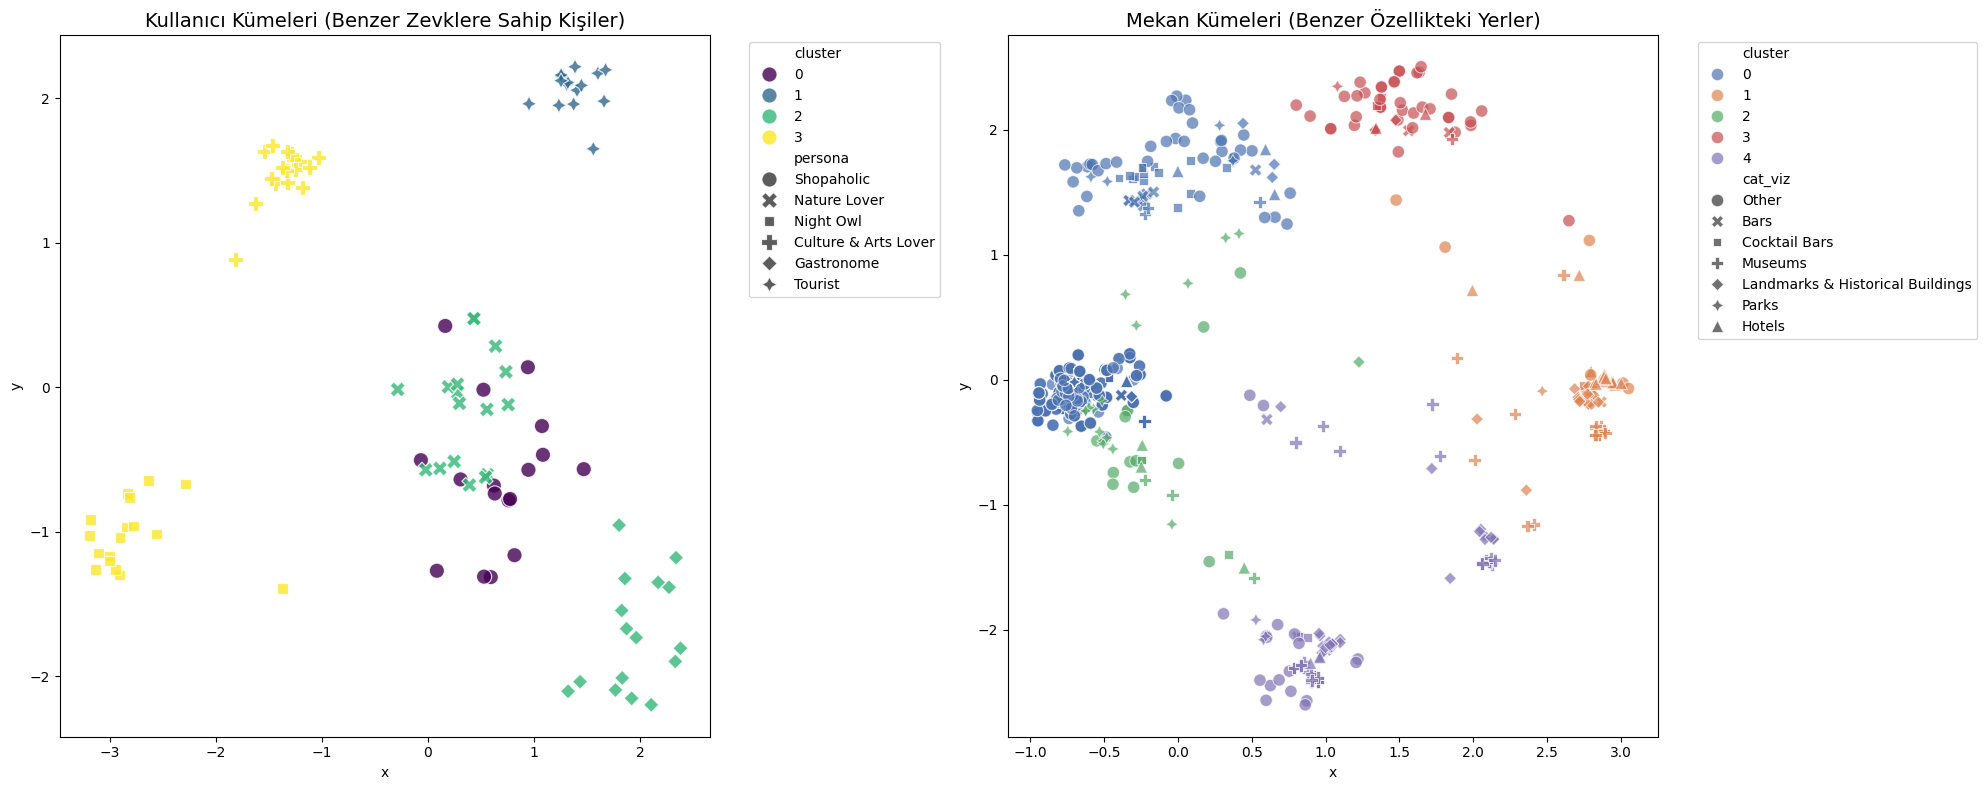

In [21]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Eğer kütüphaneler yoksa bu hücrenin başına !pip install scikit-learn seaborn ekleyebilirsin

def visualize_clusters(model, data, places_df, users_df):
    print("Analiz yapılıyor, lütfen bekleyin...")
    model.eval()
    
    # 1. Modelden Vektörleri (Embeddings) Çek
    with torch.no_grad():
        embeddings = model(data.x_dict, data.edge_index_dict)
        user_emb = embeddings['user'].cpu().numpy()
        place_emb = embeddings['place'].cpu().numpy()

    # --- KULLANICI KÜMELEME (USER CLUSTERING) ---
    # Kullanıcıları personalarına göre gruplamak istiyoruz (örn: 4 grup)
    n_user_clusters = 4 
    kmeans_user = KMeans(n_clusters=n_user_clusters, random_state=42)
    user_labels = kmeans_user.fit_predict(user_emb)
    
    # Görselleştirme için 2 Boyuta İndirge (PCA)
    pca_user = PCA(n_components=2)
    user_emb_2d = pca_user.fit_transform(user_emb)
    
    users_df['cluster'] = user_labels
    users_df['x'] = user_emb_2d[:, 0]
    users_df['y'] = user_emb_2d[:, 1]

    # --- MEKAN KÜMELEME (PLACE CLUSTERING) ---
    # Mekanları kategorilerine göre gruplamak istiyoruz (örn: 5 grup)
    n_place_clusters = 5
    kmeans_place = KMeans(n_clusters=n_place_clusters, random_state=42)
    place_labels = kmeans_place.fit_predict(place_emb)
    
    # Görselleştirme (PCA)
    pca_place = PCA(n_components=2)
    place_emb_2d = pca_place.fit_transform(place_emb)
    
    places_df['cluster'] = place_labels
    places_df['x'] = place_emb_2d[:, 0]
    places_df['y'] = place_emb_2d[:, 1]

    # --- GRAFİKLERİ ÇİZ ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Kullanıcı Grafiği
    sns.scatterplot(
        data=users_df, x='x', y='y', hue='cluster', style='persona', 
        palette='viridis', s=120, ax=axes[0], alpha=0.8
    )
    axes[0].set_title('Kullanıcı Kümeleri (Benzer Zevklere Sahip Kişiler)', fontsize=14)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Mekan Grafiği
    # Görseli sadeleştirmek için sadece ana kategorileri gösterelim
    places_df['simple_cat_viz'] = places_df['category'].apply(lambda x: str(x).split(',')[0].strip())
    top_cats = places_df['simple_cat_viz'].value_counts().nlargest(6).index
    places_df['cat_viz'] = places_df['simple_cat_viz'].apply(lambda x: x if x in top_cats else 'Other')

    sns.scatterplot(
        data=places_df, x='x', y='y', hue='cluster', style='cat_viz',
        palette='deep', s=80, ax=axes[1], alpha=0.7
    )
    axes[1].set_title('Mekan Kümeleri (Benzer Özellikteki Yerler)', fontsize=14)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    print("--- DETAYLI KÜME ANALİZİ ---")
    # Kullanıcı kümelerinde hangi personalar toplanmış?
    n_clusters = 4  # Kodda 4 küme belirlemiştik
    for i in range(n_clusters):
        print(f"\n🔵 KÜME {i} İÇİNDEKİLER:")
        # Bu kümedeki en baskın 3 persona nedir?
        counts = users_df[users_df['cluster'] == i]['persona'].value_counts()
        print(counts)

    plt.tight_layout()
    plt.show()

# Fonksiyonu çalıştır
# Not: 'model', 'data', 'places_df', 'users_df' değişkenlerinin önceki hücrelerden gelmesi lazım.
visualize_clusters(model, data, places_df, users_df)

--- ANA ÇALIŞTIRMA BLOĞU ---

In [22]:
if __name__ == "__main__":
    # 1. Modeli Eğit
    model, data, places_df, users_df = train_model()
    
    # 2. Test Etmek İstediğiniz Kullanıcıları Buraya Yazın
    # Farklı personaları deneyerek modelin tutarlılığını ölçün.
    
    print("\n" + "="*40)
    print("      TEST SENARYOLARI BAŞLIYOR      ")
    print("="*40)

    # SENARYO 1: Kültür Sever (Culture & Arts Lover)
    # Beklenti: Müzeler ve Tarihi yerler önermesi
    get_recommendations_for_user("Mehmet Williams", model, data, places_df, users_df)

    # SENARYO 2: Gurme (Gastronome)
    # Beklenti: Restoran ve Kafeler önermesi
    get_recommendations_for_user("Pierre Arslan", model, data, places_df, users_df)

    # SENARYO 3: Doğa Sever (Nature Lover)
    # Beklenti: Park ve Bahçeler önermesi
    get_recommendations_for_user("Zeynep Davis", model, data, places_df, users_df)
    
    while True:
        isim = input("\nMerak ettiğiniz kullanıcı adı (Çıkış için 'q'): ")
        if isim == 'q': break
        get_recommendations_for_user(isim, model, data, places_df, users_df)

Veriler yükleniyor...
Toplam Mekân: 1000, Toplam Kullanıcı: 100
Sentetik etkileşimler üretiliyor...
Toplam Üretilen Bağlantı (Etkileşim): 458

Model Eğitimi Başlıyor...
Epoch: 000, Loss: 1.3683
Epoch: 010, Loss: 0.6164
Epoch: 020, Loss: 0.4340
Epoch: 030, Loss: 0.3388
Epoch: 040, Loss: 0.2679
Epoch: 050, Loss: 0.2007
Epoch: 060, Loss: 0.2675
Epoch: 070, Loss: 0.3159
Epoch: 080, Loss: 0.2168
Epoch: 090, Loss: 0.2774
Epoch: 100, Loss: 0.2323

      TEST SENARYOLARI BAŞLIYOR      

🔎 ANALİZ EDİLEN KULLANICI:
   ID: 1003 | İsim: Mehmet Williams
   Persona: Culture & Arts Lover (İlgi Alanları: museums, arts, landmarks)

🎯 MODELİN ÖNERİLERİ (Culture & Arts Lover için):
------------------------------------------------------------
MEKAN ADI                      | KATEGORİ             | SKOR
------------------------------------------------------------
Le Cavern                      | Dance Clubs          | 0.9237
Pont d'Iéna                    | Landmarks & Historic | 0.9220
Memorial de la Shoa

In [23]:
import pickle
import torch

# 1. Modelin ağırlıklarını kaydet
torch.save(model.state_dict(), 'gnn_model_weights.pth')

# 2. Gerekli yan verileri (artifacts) paketle
# Tahmin yaparken 'data' objesine, kullanıcı listesine ve mekan listesine ihtiyacın var.
artifacts = {
    'data': data,               # Graph yapısı (HeteroData)
    'places_df': places_df,     # Mekan detayları
    'users_df': users_df,       # Kullanıcı detayları
    'metadata': data.metadata() # Hetero model kurulumu için gerekli
}

with open('artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("✅ Model ve gerekli dosyalar başarıyla kaydedildi!")

✅ Model ve gerekli dosyalar başarıyla kaydedildi!
